# [预训练网络进行转移学习对猫与狗图像分类](https://www.mashangxue123.com/tensorflow/tf2-tutorials-images-transfer_learning.html)

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [6]:
keras = tf.keras

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


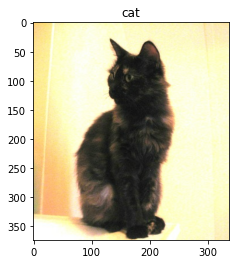

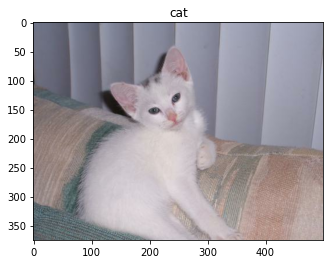

In [8]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [9]:
IMG_SIZE = 160 # 所有图像将被调整为160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 从预先训练的模型MobileNet V2创建基础模型 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 4s 0us/step


In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False
base_model.summary() # 看看基础模型架构 

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
len(model.trainable_variables)

2

In [27]:


initial_epochs = 10
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 18s 895ms/step - loss: 4.4894 - accuracy: 0.5437


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.49
initial accuracy: 0.54


In [30]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 2505s 4s/step - loss: 1.0217 - accuracy: 0.8681 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 2496s 4s/step - loss: 0.7884 - accuracy: 0.9004 - val_loss: 0.6204 - val_accuracy: 0.9316
Epoch 3/10
582/582 [==============================] - 2574s 4s/step - loss: 0.7254 - accuracy: 0.9111 - val_loss: 0.5247 - val_accuracy: 0.9411
Epoch 4/10
582/582 [==============================] - 2484s 4s/step - loss: 0.6336 - accuracy: 0.9185 - val_loss: 0.4737 - val_accuracy: 0.9445
Epoch 5/10
582/582 [==============================] - 2476s 4s/step - loss: 0.5574 - accuracy: 0.9272 - val_loss: 0.4783 - val_accuracy: 0.9428
Epoch 6/10
582/582 [==============================] - 2439s 4s/step - loss: 0.5726 - accuracy: 0.9284 - val_loss: 0.5015 - val_accuracy: 0.9424
Epoch 7/10
582/582 [==============================] - 2436s 4s/step - loss: 0.5477 - accuracy: 0.9339 - val_loss: 0.4837 - val_a

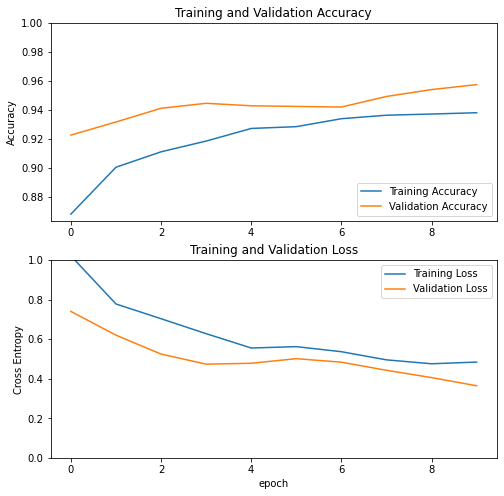

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

# 看看基础模型有多少层 
print("Number of layers in the base model: ", len(base_model.layers))

# 从此层开始微调 
fine_tune_at = 100

# 冻结‘fine_tune_at’层之前的所有层
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [33]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [34]:
len(model.trainable_variables)

58

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
582/582 [==============================] - 2979s 5s/step - loss: 0.4300 - accuracy: 0.9461 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/20
582/582 [==============================] - 2631s 5s/step - loss: 0.3585 - accuracy: 0.9577 - val_loss: 0.2072 - val_accuracy: 0.9759
Epoch 13/20
582/582 [==============================] - 2600s 4s/step - loss: 0.3011 - accuracy: 0.9649 - val_loss: 0.2130 - val_accuracy: 0.9764
Epoch 14/20
582/582 [==============================] - 2555s 4s/step - loss: 0.2595 - accuracy: 0.9706 - val_loss: 0.2144 - val_accuracy: 0.9768
Epoch 15/20
582/582 [==============================] - 2569s 4s/step - loss: 0.2292 - accuracy: 0.9738 - val_loss: 0.2121 - val_accuracy: 0.9764
Epoch 16/20
582/582 [==============================] - 2574s 4s/step - loss: 0.1990 - accuracy: 0.9765 - val_loss: 0.2122 - val_accuracy: 0.9789
Epoch 17/20
582/582 [==============================] - 2589s 4s/step - loss: 0.1931 - accuracy: 0.9770 - val_loss: 0.1996 

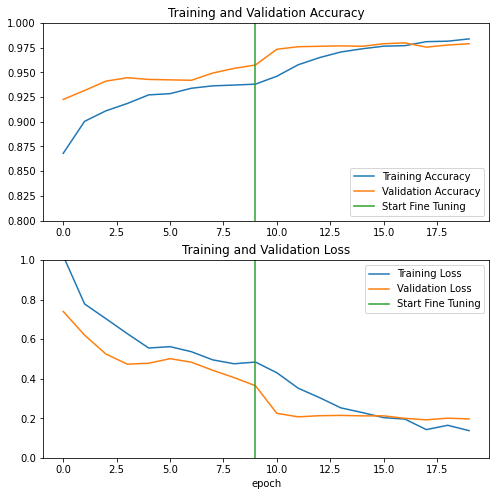

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()